# PANDA EfficientNet-B0 Baseline with 36 x tiles_256

Hi everyone,

I'm here to show you how to train a single efficientnet-b0 model to get LB 0.87

This is inference kernel and the Training kernel is avalilable here: https://www.kaggle.com/haqishen/train-efficientnet-b0-w-36-tiles-256-lb0-87



# TTA
    
Tile extraction start from different point (by adding more white padding)

comments 
- picture <br>
(mine) level 2, 128 X 128 X 16, mode 0 <br>
(his) level 1, 256 X 256 X 36, mode 0 and 2<br>
- normalizeation<br>
(mine) imagenet<br>
(his) /255 [0,1]<br>
- score <br>
(mine) isup_grade <br>
(his) gleason scores <br>

In [1]:
import os
import sys
sys.path.append('../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master')

In [2]:
import skimage.io
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from efficientnet_pytorch import EfficientNet

In [3]:
COMP_DIR = '../input/prostate-cancer-grade-assessment'
train_df = pd.read_csv(os.path.join(COMP_DIR, 'train.csv'))
test_df = pd.read_csv(os.path.join(COMP_DIR, 'test.csv'))
sub_df = pd.read_csv(os.path.join(COMP_DIR, 'sample_submission.csv'))

In [4]:
model_dir = '../input/panda-public-models'
image_folder = os.path.join(COMP_DIR, 'test_images')
is_test = os.path.exists(image_folder)  # IF test_images is not exists, we will use some train images.

image_folder = image_folder if is_test else os.path.join(COMP_DIR, 'train_images')
df = test_df if is_test else train_df.loc[:100]

class config:
    SZ = 256
    IMG_SIZE = 256
    N = 36
    BS = 8 # batch size
    NUM_WORKERS = 4


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print(image_folder)

../input/prostate-cancer-grade-assessment/train_images


# Model

In [5]:
class MyModel(nn.Module):
    def __init__(self, out_dim=5):
        super(MyModel, self).__init__()
        self.enet = EfficientNet.from_name('efficientnet-b0')
        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()

    def forward(self, x):
        x = self.enet(x)
        x = self.myfc(x)
        return x

In [6]:
model = MyModel()
model_path = os.path.join(model_dir, 'cls_effnet_b0_Rand36r36tiles256_big_bce_lr0.3_augx2_30epo_model_fold0.pth')
model.load_state_dict(torch.load(model_path, map_location=lambda storage, loc:storage), strict=True)
model = model.to(device)
next(model.parameters()).is_cuda

True

# Dataset

In [7]:
def get_tiles(img, mode=0):
    result = []
    
    h, w, c = img.shape
    pad_h = (config.SZ - h % config.SZ) % config.SZ + ((config.SZ * mode) // 2)
    pad_w = (config.SZ - w % config.SZ) % config.SZ + ((config.SZ * mode) // 2)

    img2 = np.pad(img, [[pad_h // 2, pad_h - pad_h // 2], 
                        [pad_w // 2, pad_w - pad_w//2], 
                        [0,0]], constant_values=255)
    img3 = img2.reshape(
        img2.shape[0] // config.SZ,
        config.SZ,
        img2.shape[1] // config.SZ,
        config.SZ,
        3
    )
    
    img3 = img3.transpose(0, 2, 1, 3, 4).reshape(-1, config.SZ, config.SZ, 3) # (783, 256, 256, 3)

    # all tile pixel < a piece of white
    n_tiles_with_info = (img3.reshape(img3.shape[0], -1).sum(1) < config.SZ ** 2 * 3 * 255).sum() # number of having image
    
    # supplement
    if len(img3) < config.N:
        img3 = np.pad(img3, [ [0, config.N-len(img3)], [0,0],[0,0],[0,0]], constant_values=255)
        
    idxs = np.argsort(img3.reshape(img3.shape[0],-1).sum(-1))[:config.N]
    img3 = img3[idxs]
    for i in range(len(img3)):
        result.append({'img':img3[i], 'idx':i})
        
    return result, n_tiles_with_info >= config.N

(6336, 1472, 3)
True


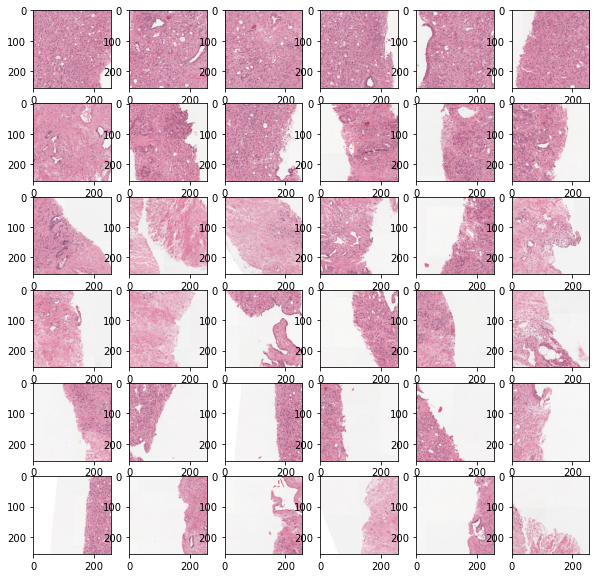

In [8]:
# test get_tiles
path = os.path.join(image_folder, train_df.loc[2, 'image_id'] + '.tiff')
img = skimage.io.MultiImage(path)[1]
print(img.shape)

a, b = get_tiles(img)
print(b)
fig, ax = plt.subplots(6, 6, figsize=(10, 10))
for i in range(6):
    for j in range(6):
        ax[i, j].imshow(a[i*6+j]['img'])

In [9]:
class PANDADataset(Dataset):
    def __init__(self, df, image_size, n_tiles=config.N, tile_mode=0 ):

        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.tile_mode = tile_mode

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        
        # 1 - read img
        row = self.df.iloc[index]
        img_id = row.image_id
        tiff_file = os.path.join(image_folder, f'{img_id}.tiff')
        
        image = skimage.io.MultiImage(tiff_file)[1]
        tiles, OK = get_tiles(image, self.tile_mode)


        # 2 - concatenate
        rows = int(np.sqrt(self.n_tiles)) # 6
        images = np.zeros((self.image_size * rows, self.image_size * rows, 3)) # placeholder (256*6, 256*6,3)
        for h in range(rows):
            for w in range(rows):
                i = h * rows + w
            
                img = tiles[i]['img'] # get the img
                img = 255 - img # to 0
            
                h1 = h * self.image_size
                w1 = w * self.image_size
                images[h1:h1+self.image_size, w1:w1+self.image_size] = img

        # 3 - normalize
#         images = 255 - images
        images = images.astype(np.float32)
        images /= 255 # (1536, 1536, 3) # to [0, 1]
        images = images.transpose(2, 0, 1) # (3, 1536, 1536)

        return torch.tensor(images)

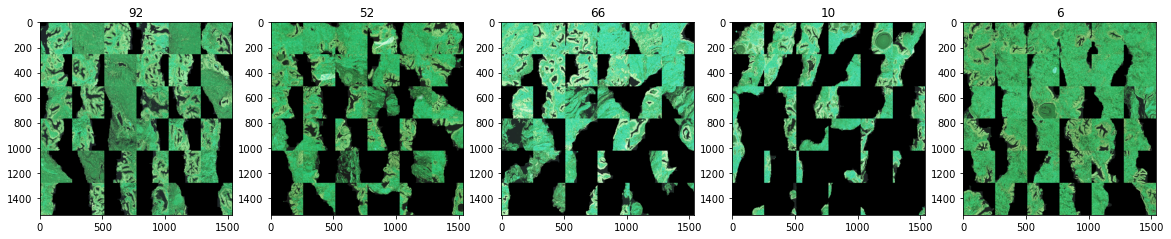

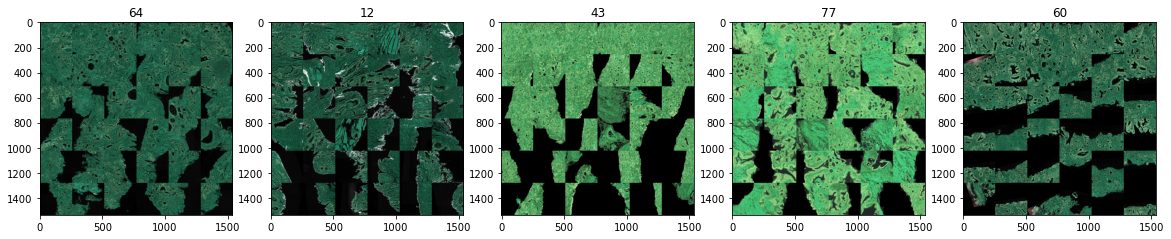

In [10]:
if not is_test:
    ds = PANDADataset(df, config.IMG_SIZE, config.N, 0)

    for i in range(2):
        fig, ax = plt.subplots(1, 5, figsize=(20, 10))
        for j in range(5):
            idx = np.random.randint(0, len(ds)) # random choose some
            img = ds[idx]
            ax[j].imshow(img.transpose(0, 1).transpose(1, 2))
            ax[j].set_title(str(idx))
            
    del ds

# Prediction

In [11]:
test_ds = PANDADataset(df, config.IMG_SIZE, config.N, 0)  # mode == 0
test_dl = DataLoader(test_ds, batch_size=config.BS, num_workers=config.NUM_WORKERS, shuffle=False)

test_ds2 = PANDADataset(df, config.IMG_SIZE, config.N, 2)  # mode == 2
test_dl2 = DataLoader(test_ds2, batch_size=config.BS, num_workers=config.NUM_WORKERS, shuffle=False)

In [12]:
LOGITS = []  # (13, 8, 5)
LOGITS2 = []
with torch.no_grad():
    for data in tqdm(test_dl):
        data = data.to(device)
        logits = model(data)
        LOGITS.append(logits)

    for data in tqdm(test_dl2):
        data = data.to(device)
        logits = model(data)
        LOGITS2.append(logits)

In [13]:
PREDS = (torch.cat(LOGITS).sigmoid().cpu() + torch.cat(LOGITS2).sigmoid().cpu()) / 2 # (101, 5)
PREDS = PREDS.sum(1).round().numpy()

df['isup_grade'] = PREDS.astype(int)
df[['image_id', 'isup_grade']].to_csv('submission.csv', index=False)
print(df.head())
print()
print(df.isup_grade.value_counts())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


                           image_id data_provider  isup_grade gleason_score
0  0005f7aaab2800f6170c399693a96917    karolinska           0           0+0
1  000920ad0b612851f8e01bcc880d9b3d    karolinska           0           0+0
2  0018ae58b01bdadc8e347995b69f99aa       radboud           4           4+4
3  001c62abd11fa4b57bf7a6c603a11bb9    karolinska           4           4+4
4  001d865e65ef5d2579c190a0e0350d8f    karolinska           0           0+0

1    29
0    19
4    16
2    16
3    12
5     9
Name: isup_grade, dtype: int64


In [14]:
!ls

__notebook__.ipynb  submission.csv
